# Dynamics Labels with pre-trained CLIP model

In [59]:
# Author: Róisín Luo

# Importing libraries

In [60]:
import sys
import os
import random
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from atomicwrites import atomic_write #we must guarantee the automicity of write operation.
import pickle

#from tqdm.notebook import trange, tqdm
#from tqdm.contrib import tzip
#from tqdm.autonotebook import tqdm
from tqdm import tqdm

import csv
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
import torchvision

from PIL import Image

%matplotlib inline

# GPU acceleration just in case

In [61]:
def get_hwacc_device_v3():

    device = torch.device('cpu')
    
    if torch.cuda.is_available():
        
        print(torch.cuda.get_device_name(0))
        print('CUDA memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
        device = torch.device('cuda')
    # MacOS
    elif hasattr(torch, "backends") and \
          hasattr(torch.backends, "mps") and \
          torch.backends.mps.is_available():
                
        device = torch.device('mps')
 
    print("GPU device is: ", device)
    
    return device

In [62]:
device = get_hwacc_device_v3()
#device = torch.device("cpu")
device

GPU device is:  mps


device(type='mps')

# Load a local image for test

In [63]:
def load_one_image(image_file, 
                   image_size = (224, 224), 
                   znorm = True,
                   znorm_mean = [0.485, 0.456, 0.406],
                   znorm_std = [0.229, 0.224, 0.225]
                  ):
    image = Image.open(image_file)
    image = np.asarray(image)

    #scaling to [0, 1]
    image = image / 255.

    #Some image may have alpha channel. We drop the alpha channel.
    #dropping alpha channel
    if len(image.shape) > 2 and image.shape[2] == 4:
        image = image[:, :, :3]

    
    if znorm == False:
        znorm_mean = 0
        znorm_std = 1
        
    transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(image_size),
                torchvision.transforms.Normalize(mean = znorm_mean, std = znorm_std)
                   ])  

    image = transforms(image)
        
    return image

In [64]:
image = load_one_image(image_file = "testimages/battery.jpg", znorm = False)

In [65]:
image.shape

torch.Size([3, 224, 224])

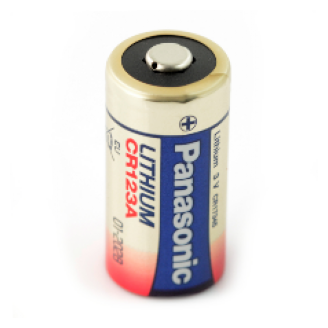

In [30]:
plt.figure(figsize=(4,4))
plt.imshow(image.permute(1,2,0).numpy())
plt.axis('off')
plt.show()

# Loading pre-trained CLIP model

In [52]:
label_1 = "A Lithium battery"
label_2 = "electonic device"
label_3 = "battery used for portable devices"
label_4 = "animals"

labels = [label_1, label_2, label_3, label_4]

In [53]:
labels

['A Lithium battery',
 'electonic device',
 'battery used for portable devices',
 'animals']

In [54]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

inputs = processor(text = labels, images = image, return_tensors = "pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [55]:
probs.shape

torch.Size([1, 4])

In [56]:
probs = probs.squeeze(0)

In [57]:
probs.shape

torch.Size([4])

In [58]:
for label, prob in zip(labels, probs.detach().numpy()):
    print(f"{label}: {prob:.2f}")

A Lithium battery: 0.42
electonic device: 0.16
battery used for portable devices: 0.39
animals: 0.02
